In [1]:
from memory_profiler import memory_usage
mem_usage = memory_usage(-1, interval=1, timeout=1)
print(mem_usage)

[65.015625]


In [2]:
import os
import sys
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import time
import seaborn
import cv2
import PIL
import random
import multiprocessing
import gc

import torch
import torchvision
import torchio as tio

from PIL import Image
from functools import partial
from tqdm import tqdm
from glob import glob

import SimpleITK as sitk
import pydicom as dcm

In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from torchvision import datasets
from torchvision.transforms import *
from torchvision.transforms import Compose

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.autograd import Variable

In [5]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


In [6]:
print("torch 버전 : ", torch.__version__)
print("python 버전 : ", sys.version)

torch 버전 :  1.10.1
python 버전 :  3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)]


In [7]:
torch.cuda.is_available()

True

In [8]:
if torch.cuda.is_available():
    device="cuda"
else:
    device="cpu"
    
print(device)

cuda


In [9]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4090'

In [10]:
torch.cuda.device_count()

2

In [11]:
multiprocessing.cpu_count()

36

In [12]:
gc.collect()
torch.cuda.empty_cache()

In [13]:
CFG={'Image_Size':256,
    'EPOCHS':500,
    'BATCH_SIZE':2,
    'Learning_rate':1e-3,
    'beta_1':0.9,
    'beta_2':0.99,
    'eps':0.00000001,
     'weight_decay':0.000001,
    'Channel_size':8,
    'SEED':42}

In [14]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

seed_everything(CFG['SEED'])

# 0. Sample Data

In [15]:
sample_path='C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\4235_LSJ\\aNew\\SPGR_P\\'
#sample_path='C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\3207_KHK\\aNew\\MAGIC_T2\\'

In [16]:
reader = sitk.ImageSeriesReader()

dicom_names = reader.GetGDCMSeriesFileNames(sample_path)

In [17]:
dicom_names

('C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\4235_LSJ\\aNew\\SPGR_P\\IMG-0071-00001.dcm',
 'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\4235_LSJ\\aNew\\SPGR_P\\IMG-0071-00002.dcm',
 'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\4235_LSJ\\aNew\\SPGR_P\\IMG-0071-00003.dcm',
 'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\4235_LSJ\\aNew\\SPGR_P\\IMG-0071-00004.dcm',
 'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\4235_LSJ\\aNew\\SPGR_P\\IMG-0071-00005.dcm',
 'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\4235_LSJ\\aNew\\SPGR_P\\IMG-0071-00006.dcm',
 'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\4235_LSJ\\aNew\\SPGR_P\\IMG-0071-00007.dcm',
 'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\4235_LSJ\\aNew\\SPGR_P\\IMG-0071-00008.dcm',
 'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\4235_LSJ\\aNew\\SPGR_P\\IMG-0071-00009.dcm',
 'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\4235_LSJ\\aNew\\SPGR_P\\IMG-0071-00010.dcm',
 'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\4235_LSJ\\aNew\\SPGR_P\\IMG-0071-00011.dcm',
 'C:\\Users\\PC00\\Desktop\\ASD_

In [18]:
reader.SetFileNames(dicom_names)

In [19]:
image = reader.Execute()

size = image.GetSize()
print("Image size:", size[0], size[1], size[2])

Image size: 512 512 160


In [20]:
print(type(image))

<class 'SimpleITK.SimpleITK.Image'>


In [21]:
size[0], size[1], size[2]

(512, 512, 160)

In [22]:
pad_image=np.array([[0]*256]*256)

In [23]:
def convert_to_numpy(sitk_volume, size):
    """convert sitk image to numpy volume"""
    img_volume = sitk.GetArrayFromImage(sitk_volume)
    img_volume = img_volume.transpose(2,1,0)
    #print(img_volume.shape)
    if img_volume.shape[0]!=CFG['Image_Size']:
        img_volume = cv2.resize(img_volume, dsize=(CFG['Image_Size'], CFG['Image_Size']))
    
    #img_volume = img_volume.transpose(1,2,0)
    
    return img_volume

In [24]:
def get_original_image(path):
    reader=sitk.ImageSeriesReader()
    dicom_names=reader.GetGDCMSeriesFileNames(path)
    
    #print("Number of Series : ", len(dicom_names))
    
    reader.SetFileNames(dicom_names)
    
    image=reader.Execute()
    size=image.GetSize()
    #print("Original size of series : ", size[0], size[1], size[2])
    img_volume=convert_to_numpy(image, size)
    
    #print("Convert size of series : ", img_volume.shape[0], img_volume.shape[1], img_volume.shape[2])
    
    return img_volume

In [25]:
img_volume=convert_to_numpy(image, size)

In [26]:
img_volume.shape, type(img_volume)

((256, 256, 160), numpy.ndarray)

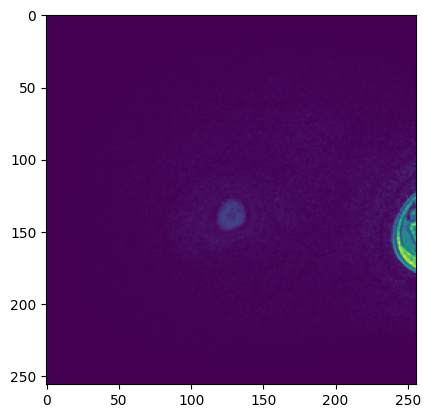

In [27]:
plt.imshow(img_volume[:,:,3])

In [28]:
mem_usage = memory_usage(-1, interval=1, timeout=1)
print(mem_usage)

[484.68359375]


## Normalization

#### z-Normalization

z = (x-mean)/std

In [29]:
def z1_normalization(img_volume):
    mean, std=np.mean(img_volume), np.std(img_volume)
    norm_img=(img_volume-mean/std)
    print(norm_img.shape)
    return norm_img

In [30]:
z_n=z1_normalization(img_volume)

(256, 256, 160)


In [31]:
print("범위 : ", np.min(z_n), " ~ ", np.max(z_n))

범위 :  -0.6082945766051938  ~  4430.391705423395


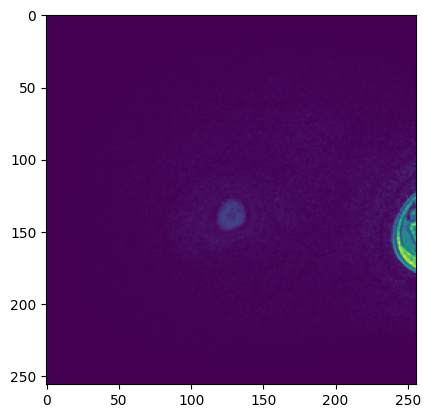

In [32]:
plt.imshow(z_n[:,:,3])

#### min_max_normalization

y=(x-max)/(max-min)

In [33]:
def min_max_normalization(img_volume):
    result=[]
    
    height=img_volume.shape[0]
    width=img_volume.shape[1]
    channel=img_volume.shape[2]
    
    for c in range(channel):
        max_value=np.max(img_volume[:,:,c])
        min_value=np.min(img_volume[:,:,c])
        img_n=(img_volume[:,:,c]-max_value)/(max_value-min_value)
        result.append(img_n)
        
    result=np.array(result)
    return result    

In [34]:
img_volume.shape

(256, 256, 160)

In [35]:
m_n=min_max_normalization(img_volume)
print("범위 : ", np.min(m_n+1), " ~ ", np.max(m_n+1))

범위 :  0.0  ~  1.0


In [36]:
print("범위 : ", np.min(m_n+1), " ~ ", np.max(m_n+1))

범위 :  0.0  ~  1.0


In [37]:
print(np.mean(m_n+1))

0.10236550063514194


In [38]:
(m_n[3])[6]

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.  

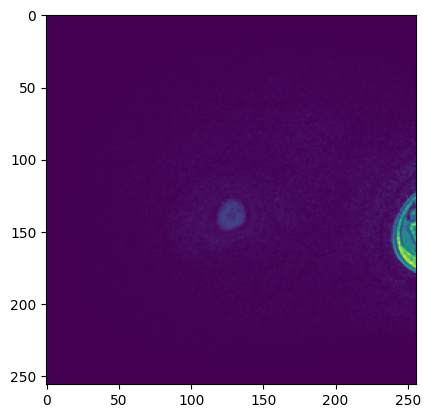

In [39]:
plt.imshow(m_n[3]+1)

#### Gaussian Filtering

In [40]:
def gaussian_filtering(img_volume,kernel_size, sigma):
    kernel1d=cv2.getGaussianKernel(kernel_size,sigma)
    kernel2d=np.outer(kernel1d, kernel1d.transpose())
    
    low_array=cv2.filter2D(img_volume, -1, kernel2d)
    high_array=img_volume-low_array+128
    
    return low_array, high_array

In [41]:
low_array, high_array=gaussian_filtering(img_volume,5, 3)

In [42]:
print("범위 : ", np.min(low_array), " ~ ", np.max(low_array))

범위 :  0  ~  3263


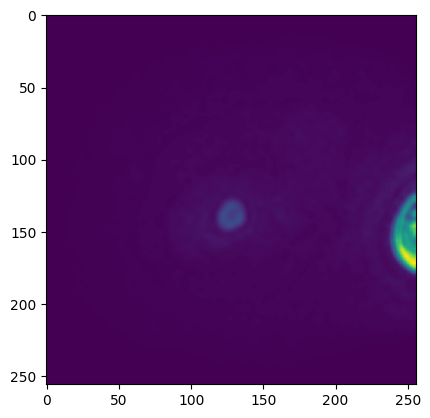

In [43]:
plt.imshow(low_array[:,:,3])

In [44]:
print("범위 : ", np.min(high_array), " ~ ", np.max(high_array))

범위 :  -2022  ~  2679


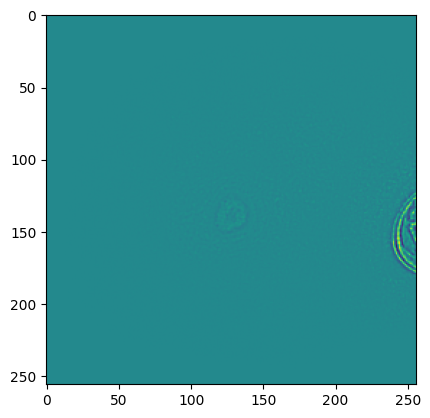

In [45]:
plt.imshow(high_array[:,:,3])

In [46]:
low_array[100,100,3], high_array[100,100,3]

(53, 118)

In [47]:
mem_usage = memory_usage(-1, interval=1, timeout=1)
print(mem_usage)

[691.3125]


# 1. Get path path
ASD를 먼저 TC를 뒤에 배치 , 모든 image에 대한 path를 리스트에 넣어버리기

In [48]:
path_asd='C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\'
path_control='C:\\Users\\PC00\\Desktop\\ASD_data\\CONTROL\\'

asd_p=os.listdir(path_asd)
control_p=os.listdir(path_control)

#sample_path='C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\3207_KHK\\aNew\\MAGIC_T2\\'
#path=path_asd+index+'\\'+'aNew\\SPGR_P\\'
#image=get_image(path)

#MRI_image=['SPGR_P', 'MAGIC_T2', 'DTI']
MRI_image=['SPGR_P']
all_image_path=[]

for name in asd_p:
    path=''
    for image in MRI_image:
        path=path_asd+name+'\\'+'aNew'+'\\'
        path=path+image+'\\'
        if 'Test' in path or '3564' in path or '3395' in path or '3278' in path or '3466' in path or '3624' in path or '3603' in path or '3632' in path or '3663' in path:
            pass
        else:
            all_image_path.append(path)
print("ASD Image Data : " , len(all_image_path)) 
for name in control_p:
    path=''
    for image in MRI_image:
        path=path_control+name+'\\'+'aNew'+'\\'
        path=path+image+'\\'
        if 'Test' in path or '3564' in path or '3395' in path or '3278' in path or '3466' in path or '3624' in path or '3603' in path or '3632' in path or '3663' in path:
            pass
        else:
            all_image_path.append(path)
        
print("ASD+TC Image Data : " ,len(all_image_path))

ASD Image Data :  203
ASD+TC Image Data :  261


In [49]:
for info in all_image_path:
    print(info)    

C:\Users\PC00\Desktop\ASD_data\ASD\1101_ASY\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\ASD\1111_KJW\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\ASD\1113_LJH\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\ASD\1321_KSH\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\ASD\1332_LJM\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\ASD\1542_KYL\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\ASD\1543_BYS\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\ASD\1563_CYS\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\ASD\1659_YHS\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\ASD\1692_CMK\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\ASD\1694_LDW\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\ASD\1712_SHJ\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\ASD\1727_SYS\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\ASD\1734_PJW\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\ASD\1736_KSJ\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\ASD\1746_YDK\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\ASD\1751_CYS\aNew\SPGR_P\
C:\Users\PC00\Desktop\ASD_data\

# 2. Make Label
One-hot Encoding도 해야함

In [50]:
label=np.array([1]*203+[0]*(261-203), dtype=np.int64)
#label=torch.tensor(label)

In [51]:
print(len(label))

261


In [52]:
n=np.unique(label, axis=0)
n=n.shape[0]

label=np.eye(n)[label]
print(n)

2


# 3. Divide Data

Train and Test Data

all_image_path : 모든 image path, label : 모든 label

In [53]:
S={'Train_Size' : 0.6,
  'Val_Size':0.2,
  'Test_Size' : 0.2}

Train and Validation Data

In [54]:
train_path, val_path, train_label, val_label=train_test_split(all_image_path, label, test_size=0.2, random_state=CFG['SEED'])

In [55]:
print(len(train_path), len(val_path), len(train_label), len(val_label))

208 53 208 53


In [56]:
train_asd=0
train_tc=0
for path in train_path:
    if 'CONTROL' in path:
        train_tc+=1
    
train_asd=len(train_path)-train_tc      
print("Train ASD : ", train_asd)
print("Train TC : ", train_tc)

Train ASD :  160
Train TC :  48


In [57]:
val_asd=0
val_tc=0
for path in val_path:
    if 'CONTROL' in path:
        val_tc+=1
    
val_asd=len(val_path)-val_tc      
print("Val ASD : ", val_asd)
print("Val TC : ", val_tc)

Val ASD :  43
Val TC :  10


Test Data

In [58]:
test_asd='C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\Test\\'
test_control='C:\\Users\\PC00\\Desktop\\ASD_data\\CONTROL\\Test\\'

test_asd_p=os.listdir(test_asd)
test_control_p=os.listdir(test_control)

#MRI_image=['SPGR_P','MAGIC_T2']
MRI_image=['MAGIC_T2']
test_image_path=[]

for name in test_asd_p:
    path=''
    for image in MRI_image:
        path=test_asd+name+'\\'+'aNew'+'\\'
        path=path+image+'\\'
        test_image_path.append(path)
print("Test ASD Image Data : " , len(test_image_path)) 
for name in test_control_p:
    path=''
    for image in MRI_image:
        path=test_control+name+'\\'+'aNew'+'\\'
        path=path+image+'\\'
        test_image_path.append(path)
        
print("Test ASD+TC Image Data : " ,len(test_image_path))

Test ASD Image Data :  10
Test ASD+TC Image Data :  20


In [59]:
for p in test_image_path:
    print(p)

C:\Users\PC00\Desktop\ASD_data\ASD\Test\4837_KDK_DL\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\4838_KKW_DL\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\4839_PRK_DL\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\4859_PJH_DL\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\4881_JWJ\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\5010_PHS\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\5023_PDK\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\5036_HKM\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\5102_KMJ\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\ASD\Test\5115_HW\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\CONTROL\Test\4371_SHJ\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\CONTROL\Test\4582_MSH\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\CONTROL\Test\4808_KTH\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\CONTROL\Test\4917_JSO\aNew\MAGIC_T2\
C:\Users\PC00\Desktop\ASD_data\CONTROL\Test\4931_LSY\aNew\MAGIC_T2\
C:\Users\

In [60]:
test_label=np.array([1]*10+[0]*10, dtype=np.int64)
#label=torch.tensor(label)

In [61]:
print(len(test_label))

20


In [62]:
n=np.unique(test_label, axis=0)
n=n.shape[0]

test_label=np.eye(n)[test_label]
print(n)

2


In [63]:
test_label

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

# 4. Transforms and Augmentation

## 1. T1 Images -> (256,256,188), T2 Images -> (256, 256, 34)

In [64]:
pad_image=[[0]*256]*256

In [65]:
def T1_resize(img_volume, plus_image):
    #(256, 256, 188)
    
    want_channel=188
    original_channel=img_volume.shape[0]
    difference=abs(want_channel-original_channel)
  
    #차이가 짝수이면
    if difference==0:
        return img_volume
    else:
        img_volume=list(img_volume)
        if difference%2==0:
            #front & behind
            for _ in range(difference//2):
                img_volume.insert(0, plus_image)
                img_volume.insert(len(img_volume), plus_image)
                
            return np.array(img_volume)
        
        else:
            #front
            for _ in range(difference//2):
                img_volume.insert(0, plus_image)
            #behind    
            for _ in range(difference//2+1):
                img_volume.insert(len(img_volume), plus_image)
                
            return np.array(img_volume)

In [66]:
def T2_resize(img_volume, plus_image):
    #(256, 256, 34)
    
    want_channel=34
    original_channel=img_volume.shape[0]
    difference=abs(want_channel-original_channel)
  
    if difference==0:
        return img_volume
    else:
        img_volume=list(img_volume)
        #차이가 짝수이면
        if difference%2==0:
            #front & behind
            for _ in range(difference//2):
                img_volume.insert(0, plus_image)
                img_volume.insert(len(img_volume), plus_image)
                
            return np.array(img_volume)
        
        else:
            #front
            for _ in range(difference//2):
                img_volume.insert(0, plus_image)
            #behind    
            for _ in range(difference//2+1):
                img_volume.insert(len(img_volume), plus_image)
                
            return np.array(img_volume)

In [67]:
def convert_to_numpy(sitk_volume, size):
    """convert sitk image to numpy volume"""
    img_volume = sitk.GetArrayFromImage(sitk_volume)
    img_volume = img_volume.transpose(2,1,0)
    #print(img_volume.shape)
    if img_volume.shape[0]!=CFG['Image_Size']:
        img_volume = cv2.resize(img_volume, dsize=(CFG['Image_Size'], CFG['Image_Size']))
    
    #img_volume = img_volume.transpose(1,2,0)
    
    return img_volume

In [68]:
def get_image(path):
    reader=sitk.ImageSeriesReader()
    dicom_names=reader.GetGDCMSeriesFileNames(path)
    
    #print("Number of Series : ", len(dicom_names))
    
    reader.SetFileNames(dicom_names)
    
    image=reader.Execute()
    size=image.GetSize()
    #print("Original size of series : ", size[0], size[1], size[2])
    img_volume=convert_to_numpy(image, size)
    
    img_volume=img_volume.transpose(2,1,0)
    
    if 'SPGR_P' in path:
        img_volume=T1_resize(img_volume, pad_image)
        #img_volume=T1_crop(img_volume)
    elif 'MAGIC_T2' in path:
        img_volume=T2_resize(img_volume, pad_image)
        #img_volume=T2_crop(img_volume)
    #print("Convert size of series : ", img_volume.shape[0], img_volume.shape[1], img_volume.shape[2])
    
    return img_volume

# Cropping

In [69]:
def T1_crop(img_volume):
    area=(25, 45, 215, 210)
    img_crop_volume=[]
    for i in range(img_volume.shape[0]):
        img=img_volume[i].astype(np.uint8)
    
        img=Image.fromarray(np.uint8(img))

        img=img.crop(area)
        img=np.array(img)
        img=list(img)
        img_crop_volume.append(img)
  
    img_crop_volume=np.array(img_crop_volume)
    return img_crop_volume

def T2_crop(img_volume):
    area=(65, 45, 205, 205)
    img_crop_volume=[]
    for i in range(img_volume.shape[0]):
        img=img_volume[i].astype(np.uint8)
    
        img=Image.fromarray(np.uint8(img))

        img=img.crop(area)
        img=np.array(img)
        img=list(img)
        img_crop_volume.append(img)
  
    img_crop_volume=np.array(img_crop_volume)
    return img_crop_volume

In [70]:
T1_path='C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\1563_CYS\\aNew\\SPGR_P\\'
T2_path='C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\1563_CYS\\aNew\\MAGIC_T2\\'
#DTI_path='C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\1563_CYS\\aNew\\DTI\\'

In [71]:
T1_sample_image=get_original_image(T1_path)
T2_sample_image=get_original_image(T2_path)
#DTI_sample_image=get_image(DTI_path)

In [72]:
rT1_sample_image=get_image(T1_path)
rT2_sample_image=get_image(T2_path)

In [73]:
T1_sample_image=T1_sample_image.transpose(2,0,1)
T2_sample_image=T2_sample_image.transpose(2,0,1)

In [74]:
print('T1 size : ', T1_sample_image.shape)
print('T2 size : ', T2_sample_image.shape)

T1 size :  (144, 256, 256)
T2 size :  (28, 256, 256)


In [75]:
print('rT1 size : ', rT1_sample_image.shape)
print('rT2 size : ', rT2_sample_image.shape)

rT1 size :  (188, 256, 256)
rT2 size :  (34, 256, 256)


In [76]:
cT1_sample_image=T1_crop(rT1_sample_image)
cT2_sample_image=T2_crop(rT2_sample_image)

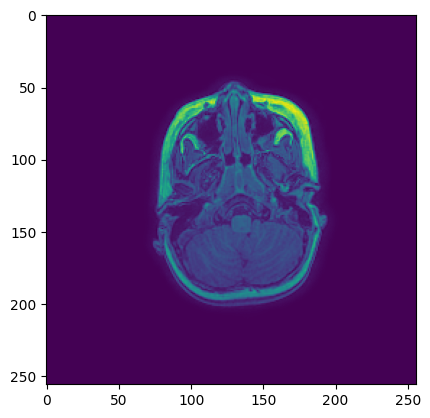

In [77]:
plt.imshow(rT1_sample_image[45])

In [78]:
s=rT1_sample_image[45]
s=torch.tensor(s)
area=(25, 45, 215, 210)
c=torchvision.transforms.functional.crop(s, )

TypeError: crop() missing 4 required positional arguments: 'top', 'left', 'height', and 'width'

In [ ]:
print('cT1 size : ', cT1_sample_image.shape)
print('cT2 size : ', cT2_sample_image.shape)

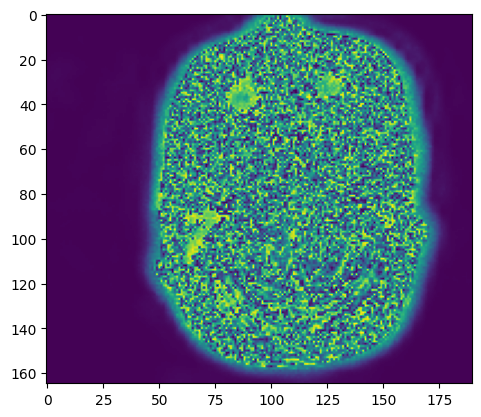

In [79]:
plt.imshow(cT1_sample_image[45])

In [80]:
def cmin_max_normalization(img_volume):
    result=[]
    
    height=img_volume.shape[1]
    width=img_volume.shape[2]
    channel=img_volume.shape[0]
    
    for c in range(channel):
        max_value=np.max(img_volume[:,:,c])
        min_value=np.min(img_volume[:,:,c])
        img_n=(img_volume[:,:,c]-max_value)/(max_value-min_value)
        result.append(img_n)
    
    result=np.array(result)
    print(result.shape)
    return result    

In [81]:
cm_n=cmin_max_normalization(cT1_sample_image)
print("범위 : ", np.min(cm_n), " ~ ", np.max(cm_n))

(188, 188, 165)
범위 :  0.0  ~  51.0


## 2. Data Transform and Augmentation

In [82]:
'''
class Normalize(torch.nn.Module):
    def __init__(self, mean, std, inplace=False):
        super().__init__()
        self.mean=mean
        self.std=std
        self.inplace=inplace
        
    def forward(self, tensor):
        return F.normalize(tensor, self.mean, self.std, self.inplace)
        
    def __repr__(self) -> str:
        return f"{self.__class__.name__}(mean={self.mean}, std={self.std})"
'''

'\nclass Normalize(torch.nn.Module):\n    def __init__(self, mean, std, inplace=False):\n        super().__init__()\n        self.mean=mean\n        self.std=std\n        self.inplace=inplace\n        \n    def forward(self, tensor):\n        return F.normalize(tensor, self.mean, self.std, self.inplace)\n        \n    def __repr__(self) -> str:\n        return f"{self.__class__.name__}(mean={self.mean}, std={self.std})"\n'

In [83]:
#mport torchio as tio

#ransform=tio.ZNormalization()

In [84]:
#Data transform
#Train 데이터에만 적용, Test는 x

transform=Compose([
    RandomCrop(220),
    #Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629)),
    
    #회전 필요할듯
])


In [85]:
mem_usage = memory_usage(-1, interval=1, timeout=1)
print(mem_usage)

[754.20703125]


# 5. CustomDataset

In [86]:
#T1+T2
class CustomDataset(Dataset):
    def __init__(self, path,labels, transforms=None):
        self.path=path
        self.labels=torch.from_numpy(labels)
        self.transforms=transforms
        
    def __getitem__(self, idx):
        #add label
        
        state=self.labels[idx]
        #state=torch.from_numpy(state)
        state=state.cuda()
        
        #get data
        #print(self.path[idx])
        
        image=get_image(self.path[idx])
        image=np.array(image, dtype=np.int64)
        image=torch.from_numpy(image)
        
        #gray channel(1), height, weight, depth
        image=torch.reshape(image,(1,image.shape[0], image.shape[1], image.shape[2]))
        
        if self.transforms:
            image = self.transforms(image)
        
        image=image.cuda()
        #print(image.shape)
        
        return image, state
        
    def __len__(self):
        return len(self.labels)   

## 1. Dataset 정의

In [87]:
train_data=CustomDataset(train_path, train_label)
val_data=CustomDataset(val_path, val_label)

test_data=CustomDataset(test_image_path, test_label) # 나중에 augmentation할 때 적용 하면 안됨

In [88]:
n=random.randint(0,len(train_label))
print(n)

163


In [89]:
train_data.__getitem__(n)

(tensor([[[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
 
          ...,
 
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0

## 2. DataLoader 정의

In [90]:
train_dataloader=DataLoader(train_data, batch_size=CFG['BATCH_SIZE'],shuffle=True)
validation_dataloader=DataLoader(val_data, batch_size=CFG['BATCH_SIZE'], shuffle=True)
test_dataloader=DataLoader(test_data, batch_size=CFG['BATCH_SIZE'],shuffle=True)

In [91]:
train_features, train_labels=next(iter(train_dataloader))

In [92]:
mem_usage = memory_usage(-1, interval=1, timeout=1)
print(mem_usage)

[2144.5625]


# 6. Model

## 1. 3D CSResNET-18 Model

3D CSResNet-18 = 3D ResNet-18 + CS BLOCK(CBAM)

In [93]:
device='cuda'

#### 1. CBAM -> Channel attention and spatial attention

In [94]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg','max']):
        super(ChannelGate, self).__init__()
        self.gate_channels=gate_channels
        self.mlp=nn.Sequential(
                        Flatten(),
                        nn.Linear(gate_channels, gate_channels // reduction_ratio),
                        nn.ReLU(),
                        nn.Linear(gate_channels // reduction_ratio, gate_channels)
        )
        self.pool_types=pool_types
        
    def forward(self, x):
        channel_att_sum=None
        #print("Input of Channel gate shape : ", x.size(0), x.size(1), x.size(2), x.size(3)) # 8 64 17 64 64
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool3d( x, (x.size(2), x.size(3), x.size(4)), stride=(x.size(2), x.size(3), x.size(4)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool3d( x, (x.size(2), x.size(3), x.size(4)), stride=(x.size(2), x.size(3), x.size(4)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool3d( x, (x.size(2), x.size(3), x.size(4)), stride=(x.size(2), x.size(3), x.size(4)))
                channel_att_raw = self.mlp( lp_pool )
                
            if channel_att_sum is None:
                channel_att_sum=channel_att_raw
            else:
                channel_att_sum=channel_att_sum+channel_att_raw
                
        scale = F.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).unsqueeze(4).expand_as(x)
        return x*scale

In [95]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm3d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

In [96]:
class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size=7
        self.compress=ChannelPool()
        self.spatial=BasicConv(2,1, kernel_size, stride=1, padding=(kernel_size-1)//2, relu=False)
        
    def forward(self, x):
        x_compress=self.compress(x)
        x_out=self.spatial(x_compress)
        scale=F.sigmoid(x_out) #broadcasting
        return x*scale

In [97]:
class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg','max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate=ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate=SpatialGate()
            
    def forward(self, x):
        x_out=self.ChannelGate(x)
        if not self.no_spatial:
            x_out=self.SpatialGate(x_out)
            
        return x_out

#### 2. General 3DResNet-18 Model

In [98]:
def get_inplanes():
    return [64, 128, 256, 512]

def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)

def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None, CBAM_use=False):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride
        
        if CBAM:
            self.cbam=CBAM(planes, 16)
        else:
            self.cbam=None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
            
        if not self.cbam is None:
            out=self.cbam(out)

        out += residual
        out = self.relu(out)
        
        return out

In [99]:
class ResNet18(nn.Module):
    def __init__(self, 
                 block, #Basicblock
                 layers, #[2,2,2,2]
                 block_inplanes, #[64, 128, 256, 512]
                 in_channels, #1
                 out_channels, #64
                 shortcut_type='B',
                 att_type=None,
                 stride=2, 
                 n_classes=2): #1, 64
        super().__init__()

        self.in_planes=block_inplanes[0]
        self.no_max_pool=False

        self.conv1=nn.Conv3d(in_channels, self.in_planes, kernel_size=(7,7,7), stride=(1,2,2), padding=(7//2,3,3), bias=False)
        self.bn1=nn.BatchNorm3d(out_channels)
        self.relu=nn.ReLU(inplace=True) #? -> 기존의 데이터를 연산의 결괏값으로 대체하는 것
        self.maxpool=nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        
        self.layer1=self._make_layer(block, block_inplanes[0], layers[0], shortcut_type)
        self.layer2=self._make_layer(block, block_inplanes[1], layers[1], shortcut_type, stride=2)
        self.layer3=self._make_layer(block, block_inplanes[2], layers[2], shortcut_type, stride=2)
        self.layer4=self._make_layer(block, block_inplanes[3], layers[3], shortcut_type, stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1,1,1))
        self.fc=nn.Linear(block_inplanes[3]*block.expansion, n_classes)
        self.sigmoid=nn.Sigmoid()
        
        if att_type=='BAM':
            self.bam1=BAM(64*block.expansion)
            self.bam2=BAM(128*block.expansion)
            self.bam3=BAM(256*block.expansion)
        else:
            self.bam1, self.bam2, self.bam3=None, None, None
        
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # He initialization
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1) # 초기값  설정
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample=None
        if stride!=1 or self.in_planes != planes*block.expansion:
            if shortcut_type=='A':
                downsample=partial(self._dwonsample_basic_block, planes=planes * block.expansion, stride=stride)
            else:
                downsample=nn.Sequential(
                    conv1x1x1(self.in_planes, planes*block.expansion, stride),
                    nn.BatchNorm3d(planes*block.expansion),
                )

        layers=[]
        layers.append(
            block(in_planes=self.in_planes, planes=planes, stride=stride, downsample=downsample, CBAM_use=True),
        )
        

        self.in_planes=planes*block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes, CBAM_use=True))

        return nn.Sequential(*layers)

    def forward(self, x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        if not self.no_max_pool:
            x=self.maxpool(x)

        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)

        x=self.avgpool(x)

        x=x.view(x.size(0), -1)
        x=self.fc(x)
        x=self.sigmoid(x)
        #print('out : ', x.shape)
        return x

In [100]:
model=ResNet18(BasicBlock, [2,2,2,2], get_inplanes(), 1, 64)

In [101]:
model=model.to(device)

In [102]:
model

ResNet18(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (cbam): CBAM(
        (ChannelGate): ChannelGate(
          (mlp): Sequential(
            (0): Flatten()
            (1): Linear(in_features=64, out_features=4, bias=True)
            (2): ReLU()
            (3):

In [103]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 33,255,610 trainable parameters


In [104]:
loss_fn=nn.BCELoss().to(device)
optimizer=torch.optim.Adam(model.parameters(), 
                           lr=CFG['Learning_rate'], 
                           betas=(CFG['beta_1'], CFG['beta_2']), 
                           eps=CFG['eps'], 
                           weight_decay=CFG['weight_decay'])

In [105]:
mem_usage = memory_usage(-1, interval=1, timeout=1)
print(mem_usage)

[2145.9609375]


# 7. Train & Validation

In [106]:
#confusio_matrix
def confusion_m(y_pred, y_true):
    return confusion_matrix(y_true, y_pred)

In [107]:
def train_loop(dataloader, model, loss_fn, optimizer):
    
    size=len(dataloader.dataset)
    print("데이터 사이즈 : ", size)
    
    train_loss, correct=0,0
    
    model.train()
    
    #autograd engine(gradient를 계산해주는 context)을 비활성화 시켜 필요한 메모리를 줄여주고 연산속도 증가
    
    for batch, (X,y) in (enumerate((dataloader))):
        #print(type(X), type(y))
        #y=y.to(device)
        X=Variable(X.to(device).float())
        y=Variable(y.to(device).float())
        pred=model(X)
        #print(pred)
        #print(y)
        loss=loss_fn(pred,y)
        train_loss+=loss.item()
        correct+=(pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
        #print('batch : ', batch)
        #print('loss : ', loss)
        #print('pred : ', pred)
        #역전파
        optimizer.zero_grad() #gradient를 0으로 초기화
        loss.requires_grad_(True)
        loss.backward() #비용 함수를 미분하여 gradient 계산
        optimizer.step() #update weight and bias
        
        if batch%10==0:
            loss, current=loss.item(), batch*len(X)
            print(f"Batch {batch} loss : {loss:>7f} [{current:>5d}/{size:>5d}]")  
        
    train_loss/=size
    correct/=size
    
    print(f"Train\n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {train_loss:>8f}\n")
    return train_loss, correct

In [108]:
def val_loop(dataloader, model, loss_fn):
    size=len(dataloader.dataset)
    
    num_batches=len(dataloader)
    val_loss, correct=0,0
    
    model.eval()
    with torch.no_grad():
        for X,y in dataloader:
            X=Variable(X.to(device).float())
            #print(X.shape)
            y=Variable(y.to(device).float())
            pred=model(X)
            #print(pred.shape)
            val_loss+=loss_fn(pred, y).item()
            correct+=(pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
            
    val_loss/=num_batches
    correct/=size
    
    print(f"Validation\n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {val_loss:>8f}\n")
    return val_loss, correct

In [109]:
train_loss_info=[]
train_acc_info=[]

val_loss_info=[]
val_acc_info=[]

start=time.time()

for t in range(CFG['EPOCHS']):
    print(f"Epoch {t+1}\n-------------------------------------------")
    start_epoch=time.time()
    train_loss, train_acc=train_loop(train_dataloader, model, loss_fn, optimizer)
    train_loss_info.append(train_loss)
    train_acc_info.append(train_acc)
    
    val_loss, val_acc=val_loop(validation_dataloader, model, loss_fn)
    val_loss_info.append(val_loss)
    val_acc_info.append(val_acc)
    
    end_epoch=time.time()
    print(f"Epcoh time : {(end_epoch-start_epoch)//60}분 {(end_epoch-start_epoch)%60} 초")
    print(f"Epoch {t+1} End\n-------------------------------------------")
    print()
    
end=time.time()

print("Epoch 걸린 시간 : ", (end-start)//60, " 분", (end-start)%60, " 초")

Epoch 1
-------------------------------------------
데이터 사이즈 :  208


C:\Users\PC00\anaconda3\envs\torch\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Batch 0 loss : 0.691822 [    0/  208]
Batch 10 loss : 1.337204 [   20/  208]
Batch 20 loss : 0.338562 [   40/  208]
Batch 30 loss : 0.157062 [   60/  208]
Batch 40 loss : 1.466278 [   80/  208]
Batch 50 loss : 0.509463 [  100/  208]
Batch 60 loss : 0.653299 [  120/  208]
Batch 70 loss : 0.639361 [  140/  208]
Batch 80 loss : 0.395138 [  160/  208]
Batch 90 loss : 0.307792 [  180/  208]
Batch 100 loss : 0.913877 [  200/  208]
Train
 Accuracy : 73.6%, Avg Loss : 0.304273

Validation
 Accuracy : 81.1%, Avg Loss : 0.474559

Epcoh time : 5.0분 48.60986280441284 초
Epoch 1 End
-------------------------------------------

Epoch 2
-------------------------------------------
데이터 사이즈 :  208
Batch 0 loss : 0.533402 [    0/  208]
Batch 10 loss : 1.951921 [   20/  208]
Batch 20 loss : 0.317096 [   40/  208]
Batch 30 loss : 0.354629 [   60/  208]
Batch 40 loss : 0.241969 [   80/  208]
Batch 50 loss : 0.284943 [  100/  208]
Batch 60 loss : 0.245506 [  120/  208]
Batch 70 loss : 0.239844 [  140/  208]
B

Batch 0 loss : 0.204715 [    0/  208]
Batch 10 loss : 0.187154 [   20/  208]
Batch 20 loss : 1.062480 [   40/  208]
Batch 30 loss : 0.204069 [   60/  208]
Batch 40 loss : 0.944096 [   80/  208]
Batch 50 loss : 0.321994 [  100/  208]
Batch 60 loss : 0.842456 [  120/  208]
Batch 70 loss : 0.305973 [  140/  208]
Batch 80 loss : 0.558820 [  160/  208]
Batch 90 loss : 0.339882 [  180/  208]
Batch 100 loss : 1.962668 [  200/  208]
Train
 Accuracy : 77.9%, Avg Loss : 0.264289

Validation
 Accuracy : 79.2%, Avg Loss : 0.549591

Epcoh time : 4.0분 35.92826294898987 초
Epoch 13 End
-------------------------------------------

Epoch 14
-------------------------------------------
데이터 사이즈 :  208
Batch 0 loss : 0.209752 [    0/  208]
Batch 10 loss : 0.919386 [   20/  208]
Batch 20 loss : 0.323677 [   40/  208]
Batch 30 loss : 0.846503 [   60/  208]
Batch 40 loss : 0.895712 [   80/  208]
Batch 50 loss : 0.245217 [  100/  208]
Batch 60 loss : 0.221273 [  120/  208]
Batch 70 loss : 0.359519 [  140/  208]

Batch 0 loss : 0.302972 [    0/  208]
Batch 10 loss : 0.988330 [   20/  208]
Batch 20 loss : 0.553790 [   40/  208]
Batch 30 loss : 0.661190 [   60/  208]
Batch 40 loss : 0.223922 [   80/  208]
Batch 50 loss : 0.176876 [  100/  208]
Batch 60 loss : 0.211420 [  120/  208]
Batch 70 loss : 0.145804 [  140/  208]
Batch 80 loss : 0.338667 [  160/  208]
Batch 90 loss : 0.114580 [  180/  208]
Batch 100 loss : 1.191537 [  200/  208]
Train
 Accuracy : 83.2%, Avg Loss : 0.212102

Validation
 Accuracy : 75.5%, Avg Loss : 0.621261

Epcoh time : 4.0분 34.401824951171875 초
Epoch 25 End
-------------------------------------------

Epoch 26
-------------------------------------------
데이터 사이즈 :  208
Batch 0 loss : 0.110215 [    0/  208]
Batch 10 loss : 0.146558 [   20/  208]
Batch 20 loss : 0.201211 [   40/  208]
Batch 30 loss : 1.499377 [   60/  208]
Batch 40 loss : 0.282309 [   80/  208]
Batch 50 loss : 1.884885 [  100/  208]
Batch 60 loss : 1.086775 [  120/  208]
Batch 70 loss : 0.176598 [  140/  208

In [110]:
mem_usage = memory_usage(-1, interval=1, timeout=1)
print(mem_usage)

[5315.2734375]


plot Train and validation loss, accuracy

In [111]:
ep=[i for i in range(1, CFG['EPOCHS']+1)]

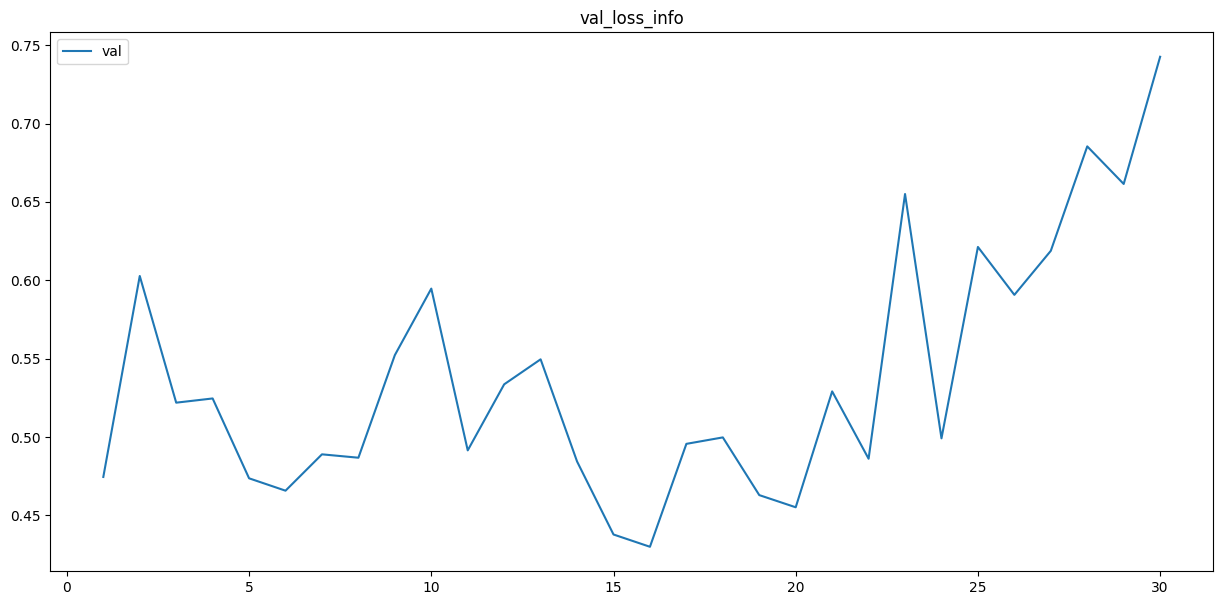

In [112]:
plt.figure(figsize=(15,7))
plt.title('val_loss_info')
plt.plot(ep,val_loss_info, label='val')
plt.legend()

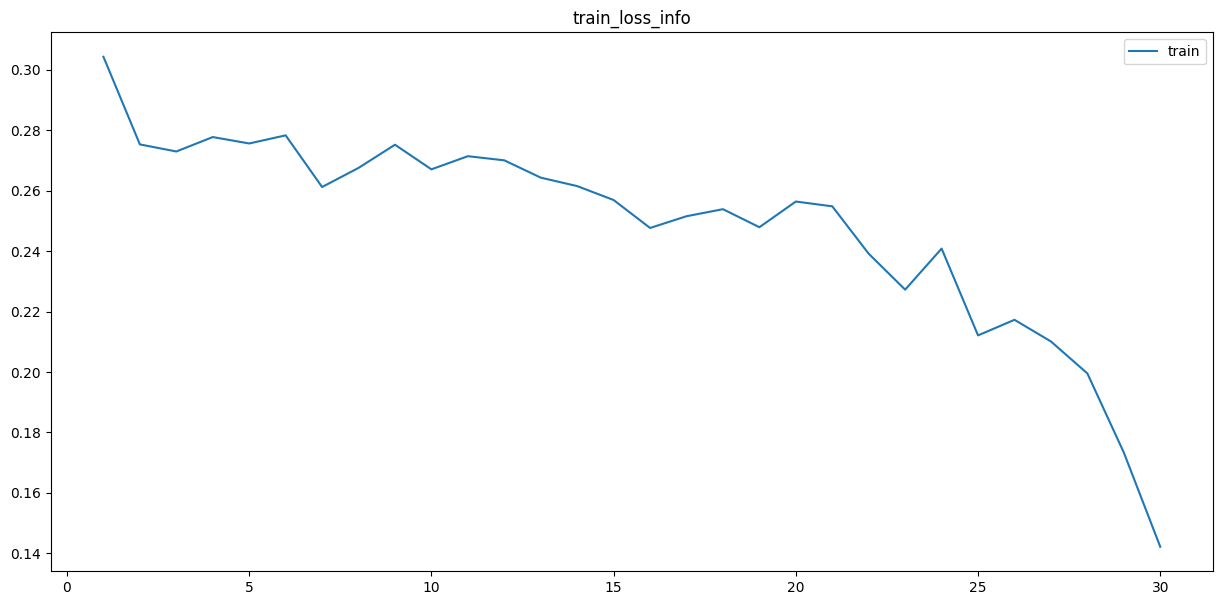

In [113]:
plt.figure(figsize=(15,7))
plt.title('train_loss_info')
plt.plot(ep, train_loss_info, label='train')
plt.legend()

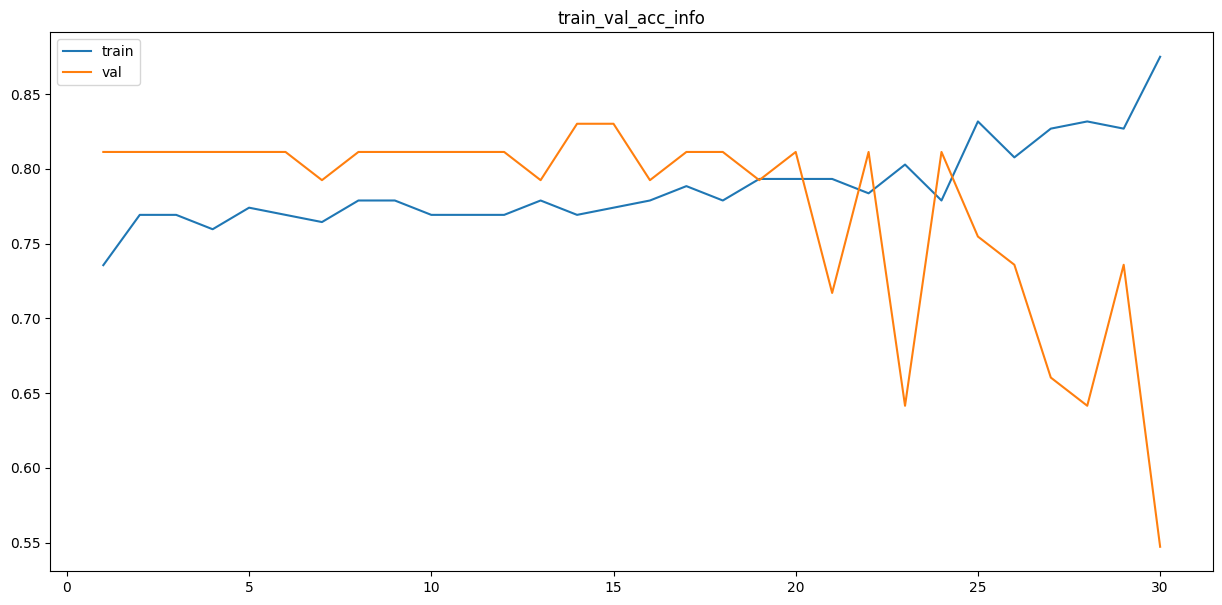

In [114]:
plt.figure(figsize=(15,7))
plt.title('train_val_acc_info')
plt.plot(ep, train_acc_info, label='train')
plt.plot(ep,val_acc_info, label='val')
plt.legend()

# 8. Save Model

In [115]:
PATH='C:\\Users\\PC00\\Desktop\\ASD_data\\model\\T1\\'

In [116]:
torch.save(model, PATH+'model.pt') #전체 모델 저장
torch.save(model.state_dict(), PATH+'model_state_dict.pt') #모델 객체의 state_dict 저장
torch.save({
    'model':model.state_dict(),
    'optimizer':optimizer.state_dict()
}, PATH+'all.tar') #여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar 값 저장 가능

# 9. Test

Test를 위한 모델 불러오기

In [117]:
model=torch.load(PATH+'model.pt') #전체 모델을 통째로 불러옴
model.load_state_dict(torch.load(PATH+'model_state_dict.pt')) #state_dict를 불러 온 후, 모델에 저장

checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

model.to(device)

ResNet18(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (cbam): CBAM(
        (ChannelGate): ChannelGate(
          (mlp): Sequential(
            (0): Flatten()
            (1): Linear(in_features=64, out_features=4, bias=True)
            (2): ReLU()
            (3):

In [118]:
#sensitivity
#양성인 것중에 양성으로 판별

#specificity
#음성인 것중에 음성으로 판별

def true_positive(p,t):
    l=len(p)
    cnt=0
    for i in range(l):
        if t[i]==1 and p[i]==1:
            cnt+=1
            
    return cnt


def true_negative(p,t):
    l=len(p)
    cnt=0
    for i in range(l):
        if t[i]==0 and p[i]==0:
            cnt+=1
    
    return cnt

In [119]:
def test_loop(dataloader,model, loss_fn, test_asd, test_tc):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)
    model.eval()
    
    test_loss, correct=0,0
    
    TP,TN=0,0
    
    with torch.no_grad():
        for X,y in dataloader:
            X=Variable(X.to(device).float())
            y=Variable(y.to(device).float())
            
            pred=model(X)
            
            #loss
            test_loss+=loss_fn(pred, y).item()
            #accuracy
            correct+=(pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
            print(pred.argmax(1))
            print(y.argmax(1))
            print()
            TP+=true_positive(pred.argmax(1), y.argmax(1))
            TN+=true_negative(pred.argmax(1), y.argmax(1))
    
    FN=test_asd-TP
    FP=test_tc-TN
    test_loss/=num_batches
    correct/=size
    
    print(f"Test Error\n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {test_loss:>8f}\n")
    print(f"True Positive : {TP}\nTrue Negative : {TN}\nFalse Positive : {FP}\nFalse Negative : {FN}\n")
    return (TP/(TP+FN))*100, (TN/(FP+TN))*100, (TP/(TP+FP))*100, (TN/(FN+TN))*100

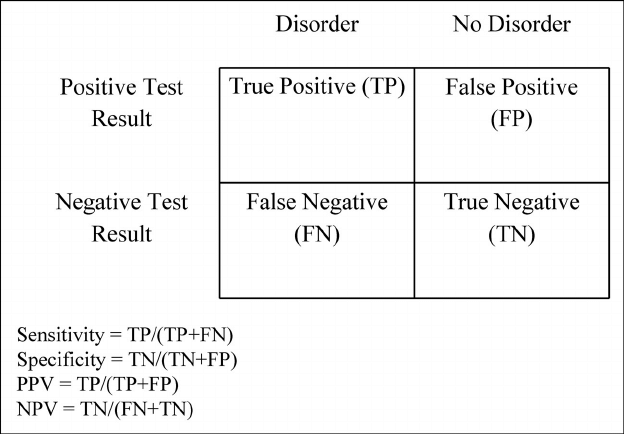

In [120]:
test_asd=10
test_tc=10

start=time.time()

sensitivity, specificity, PPV, NPV=test_loop(test_dataloader ,model, loss_fn, test_asd, test_tc)

end=time.time()

print(f"Test 걸린 시간 : {(end-start)//60} 분 {(end-start)%60:.1f} 초")

tensor([0, 0], device='cuda:0')
tensor([1, 0], device='cuda:0')

tensor([1, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')

tensor([1, 0], device='cuda:0')
tensor([1, 1], device='cuda:0')

tensor([0, 0], device='cuda:0')
tensor([0, 0], device='cuda:0')

tensor([0, 0], device='cuda:0')
tensor([0, 0], device='cuda:0')

tensor([1, 1], device='cuda:0')
tensor([1, 1], device='cuda:0')

tensor([0, 1], device='cuda:0')
tensor([1, 0], device='cuda:0')

tensor([1, 1], device='cuda:0')
tensor([0, 1], device='cuda:0')

tensor([0, 0], device='cuda:0')
tensor([0, 1], device='cuda:0')

tensor([0, 0], device='cuda:0')
tensor([1, 0], device='cuda:0')

Test Error
 Accuracy : 55.0%, Avg Loss : 1.396944

True Positive : 4
True Negative : 7
False Positive : 3
False Negative : 6

Test 걸린 시간 : 0.0 분 4.4 초


In [121]:
print(f"Sensitivity : {sensitivity:.3f}%")
print(f"Specificity : {specificity:.3f}%")
print(f"PPV : {PPV:.3f}%")
print(f"NPV : {NPV:.3f}%")

Sensitivity : 40.000%
Specificity : 70.000%
PPV : 57.143%
NPV : 53.846%
